# Google cluster data and multivariable anomaly detection example
This notebook contains an example using the real life Google cluster data. This is a 41GB dataset containing records from 1.25k different machines, while a single machine has approximately 5000-10000 records. For more information, see https://github.com/google/cluster-data.

This example will use the Memory Time-Series Network(MTNet) in the AutoML-model. This network can be easily transfered to multivariable settings as we will see in the following. For more information about the algorithm, see https://arxiv.org/abs/1809.02105.
## 0.helper function definition

In [1]:
# plot the predicted values and actual values (for the test data)
def plot_result_with_percentile_anomaly(test_df, pred_df, outliers_fraction=0.01, plot_size=None):
    # target column of dataframe is "value"
    # past sequence length is 50
    # An estimation of anomly population of the dataset
    # select the most distant prediction/reality data points as anomalies
    merge_df = pd.merge(test_df, pred_df, on='datetime')
    if plot_size is not None:
        merge_df = merge_df[:plot_size]
    diff = pd.Series(abs(merge_df['value_x'] - merge_df['value_y']))
    number_of_outliers = int(outliers_fraction*len(diff))
    threshold = diff.nlargest(number_of_outliers).min()
    anomaly = merge_df[diff > threshold]
    
    fig, axs = plt.subplots(figsize=(12, 5))
    # value_x for actial, value_y for test
    axs.plot(merge_df['datetime'], merge_df['value_y'], color='red',label='predicted values', alpha=0.6)
    axs.plot(merge_df['datetime'], merge_df['value_x'], color='blue', label='actual values',alpha=0.6)
    axs.set_title('the predicted values and actual values (for the test data)')
    axs.scatter(anomaly['datetime'].tolist(),anomaly['value_x'], color='red', label='anomalies value')

    plt.xlabel('datetime')
    plt.xticks(rotation=45)
    plt.ylabel('Max CPU rate')
    plt.legend(loc='upper left')
    plt.show()

In [2]:
def plot_result_with_uncertainty_anomaly(test_df, pred_df, uncertainty, deviation_threshold_ratio=10, plot_deviation_ratios = [5, 10],plot_size=None):
    plot_ratio1, plot_ratio2 = plot_deviation_ratios

    pred_df['uncertainty'] = uncertainty
    merge_df = pd.merge(test_df, pred_df, on='datetime')
    merge_df['diff'] = abs(merge_df['value_x'] - merge_df['value_y'])


    if plot_size is None:
        plot_df = merge_df
    else:
        plot_df = merge_df[:plot_size]

    anomaly = plot_df[plot_df['diff'] > plot_df['uncertainty']*deviation_threshold_ratio]

    fig, axs = plt.subplots(figsize=(12, 5))


    # 10 uncertainty errorbar
    axs.fill_between(plot_df['datetime'], plot_df['value_y']-plot_ratio2* plot_df['uncertainty'], plot_df['value_y']+plot_ratio2*plot_df['uncertainty'],facecolor='red',alpha=0.1,edgecolor='none', label='10 uncertainty bar')
    # 5 times uncertainty errorbar
    axs.fill_between(plot_df['datetime'], plot_df['value_y']-plot_ratio1* plot_df['uncertainty'], plot_df['value_y']+plot_ratio1*plot_df['uncertainty'],facecolor='red',alpha=.25,edgecolor='none', label='5 uncertainty bar')

    # value_x for actial, value_y for test
    axs.plot(plot_df['datetime'], plot_df['value_y'], color='red', alpha=0.6, label='predicted values')
    axs.plot(plot_df['datetime'], plot_df['value_x'], color='blue', alpha=0.6, label='actual values')
    axs.set_title('the predicted values and actual values with uncertainty quantification(for the test data)')
    axs.scatter(anomaly['datetime'].tolist(),anomaly['value_x'], color='red', label='anomalies value')

    plt.xlabel('datetime')
    plt.xticks(rotation=45)
    plt.ylabel('Max CPU rate')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
def multi_plot_result_with_percentile_anomaly(test_df, pred_df, outliers_fraction=0.01, plot_size=None):
    merge_df = pd.merge(test_df, pred_df.rename(columns={'value_x': 'pred_x', 'value_y':'pred_y' }), on='datetime')
    if plot_size is not None:
        merge_df = merge_df[:plot_size]
    diff_x = pd.Series(abs(merge_df['value_x'] - merge_df['pred_x']))
    number_of_outliers_x = int(outliers_fraction*len(diff_x))
    threshold_x = diff_x.nlargest(number_of_outliers_x).min()
    anomaly_x = merge_df[diff_x > threshold_x]
    diff_y = pd.Series(abs(merge_df['value_y'] - merge_df['pred_y']))
    number_of_outliers_y = int(outliers_fraction*len(diff_y))
    threshold_y = diff_y.nlargest(number_of_outliers_y).min()
    anomaly_y = merge_df[diff_y > threshold_y]
    
    fig, axs = plt.subplots(figsize=(12, 5))
    # value_x for actial, value_y for test
    axs.plot(merge_df['datetime'], merge_df['pred_x'], color='red',label='predicted values', alpha=0.6)
    axs.plot(merge_df['datetime'], merge_df['value_x'], color='blue', label='actual values',alpha=0.6)
    axs.plot(merge_df['datetime'], merge_df['pred_y'], color='red',label='predicted values', alpha=0.6)
    axs.plot(merge_df['datetime'], merge_df['value_y'], color='blue', label='actual values',alpha=0.6)
    axs.set_title('the predicted values and actual values (for the test data)')
    axs.scatter(anomaly_x['datetime'].tolist(),anomaly_x['value_x'], color='red', label='anomalies value')
    axs.scatter(anomaly_y['datetime'].tolist(),anomaly_y['value_y'], color='red', label='anomalies value')

    plt.xlabel('datetime')
    plt.xticks(rotation=45)
    plt.ylabel('Max CPU rate')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.0))
    plt.show()

In [4]:
def multi_plot_result_with_uncertainty_anomaly(test_df, pred_df, uncertainty, deviation_threshold_ratio=10, plot_deviation_ratios = [5, 10],plot_size=None):
    plot_ratio1, plot_ratio2 = plot_deviation_ratios

    pred_df['uncertainty_x'] = uncertainty[:, 0]
    pred_df['uncertainty_y'] = uncertainty[:, 1]
    merge_df = pd.merge(test_df, pred_df.rename(columns={'value_x': 'pred_x', 'value_y':'pred_y' }), on='datetime')
    merge_df['diff_x'] = pd.Series(abs(merge_df['value_x'] - merge_df['pred_x']))
    merge_df['diff_y'] = pd.Series(abs(merge_df['value_y'] - merge_df['pred_y']))

    if plot_size is None:
        plot_df = merge_df
    else:
        plot_df = merge_df[:plot_size]

    anomaly_x = plot_df[plot_df['diff_x'] > plot_df['uncertainty_x']*deviation_threshold_ratio]
    anomaly_y = plot_df[plot_df['diff_y'] > plot_df['uncertainty_y']*deviation_threshold_ratio]

    fig, axs = plt.subplots(figsize=(12, 5))


    # 10 uncertainty errorbar
    axs.fill_between(plot_df['datetime'], plot_df['pred_y']-plot_ratio2* plot_df['uncertainty_y'], plot_df['pred_y']+plot_ratio2*plot_df['uncertainty_y'],facecolor='red',alpha=0.1,edgecolor='none', label=str(plot_ratio2*2) + ' uncertainty bar')
    # 5 times uncertainty errorbar
    axs.fill_between(plot_df['datetime'], plot_df['pred_y']-plot_ratio1* plot_df['uncertainty_y'], plot_df['pred_y']+plot_ratio1*plot_df['uncertainty_y'],facecolor='red',alpha=.25,edgecolor='none', label=str(plot_ratio1*2) + ' uncertainty bar')
    # 10 uncertainty errorbar
    axs.fill_between(plot_df['datetime'], plot_df['pred_y']-plot_ratio2* plot_df['uncertainty_y'], plot_df['pred_y']+plot_ratio2*plot_df['uncertainty_y'],facecolor='red',alpha=0.1,edgecolor='none', label=str(plot_ratio2*2) + ' uncertainty bar')
    # 5 times uncertainty errorbar
    axs.fill_between(plot_df['datetime'], plot_df['pred_y']-plot_ratio1* plot_df['uncertainty_y'], plot_df['pred_y']+plot_ratio1*plot_df['uncertainty_y'],facecolor='red',alpha=.25,edgecolor='none', label=str(plot_ratio1*2) +' uncertainty bar')

    # 10 uncertainty errorbar
    axs.fill_between(plot_df['datetime'], plot_df['pred_x']-plot_ratio2* plot_df['uncertainty_x'], plot_df['pred_x']+plot_ratio2*plot_df['uncertainty_x'],facecolor='red',alpha=0.1,edgecolor='none', label=str(plot_ratio2*2) + ' uncertainty bar')
    # 5 times uncertainty errorbar
    axs.fill_between(plot_df['datetime'], plot_df['pred_x']-plot_ratio1* plot_df['uncertainty_x'], plot_df['pred_x']+plot_ratio1*plot_df['uncertainty_x'],facecolor='red',alpha=.25,edgecolor='none', label=str(plot_ratio1*2) + ' uncertainty bar')
    # 10 uncertainty errorbar
    axs.fill_between(plot_df['datetime'], plot_df['pred_x']-plot_ratio2* plot_df['uncertainty_x'], plot_df['pred_x']+plot_ratio2*plot_df['uncertainty_x'],facecolor='red',alpha=0.1,edgecolor='none', label=str(plot_ratio2*2) + ' uncertainty bar')
    # 5 times uncertainty errorbar
    axs.fill_between(plot_df['datetime'], plot_df['pred_x']-plot_ratio1* plot_df['uncertainty_x'], plot_df['pred_x']+plot_ratio1*plot_df['uncertainty_x'],facecolor='red',alpha=.25,edgecolor='none', label=str(plot_ratio1*2) +' uncertainty bar')


    # value_x for actial, value_y for test
    axs.plot(plot_df['datetime'], plot_df['pred_x'], color='red', alpha=0.6, label='predicted values x')
    axs.plot(plot_df['datetime'], plot_df['value_x'], color='blue', alpha=0.6, label='actual values x')
    axs.plot(plot_df['datetime'], plot_df['pred_y'], color='red', alpha=0.6, label='predicted values y')
    axs.plot(plot_df['datetime'], plot_df['value_y'], color='blue', alpha=0.6, label='actual values y')
    axs.set_title('the predicted values and actual values with uncertainty quantification(for the test data)')
    axs.scatter(anomaly_x['datetime'].tolist(),anomaly_x['value_x'], color='red', label='anomalies value')
    axs.scatter(anomaly_y['datetime'].tolist(),anomaly_y['value_y'], color='red', label='anomalies value')

    plt.xlabel('datetime')
    plt.xticks(rotation=45)
    plt.ylabel('Max CPU rate')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.0))
    plt.show()

## 1. load data

In [5]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


Since the dataset is huge, we retrieve ten machines cached for convenience. We split them using into train/val/test sets.

In [6]:
# load nyc taxi data
try:
    import pickle
    with open('dataset/machines/machine-0.pkl', 'rb') as file:
        azure1 =pickle.load(file)
except Exception as e:
    print("machine-0.pkl doesn't exist")
    #print("you can run $ANALYTICS_ZOO_HOME/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh to download nyc_taxi.csv")

In [7]:
from zoo.automl.common.util import split_input_df
train_df, val_df, test_df = split_input_df(azure1, val_split_ratio=0.1, test_split_ratio=0.1)
train_df = train_df[200:] # discard ununiform timesteps

Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.9.0-spark_2.1.0-0.6.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


Now look at the dataset. The unit of value is the max cpu rate in the previous datetime. The datetime intervals are all 5 min, while some point missing in the original dataset. We will discard the non-uniform time interval parts in preprocessing.

In [8]:
train_df.head(5)

,datetime,value
200,2019-01-01 17:00:00,8.568225
201,2019-01-01 17:05:00,13.627919
202,2019-01-01 17:10:00,13.230438
203,2019-01-01 17:15:00,13.158413
204,2019-01-01 17:20:00,8.389652


In [9]:
train_df.describe()

,value
count,2368.000000
mean,13.090700
std,2.122340
min,6.460986
25%,11.312243
50%,13.362142
75%,14.562558
max,33.508466


In [10]:
# shape of the dataframe
print("The shape of train_df is", train_df.shape)
print("The shape of val_df is", val_df.shape)
print("The shape of test_df is", test_df.shape)

The shape of train_df is (2368, 2)
The shape of val_df is (321, 2)
The shape of test_df is (321, 2)


No handles with labels found to put in legend.


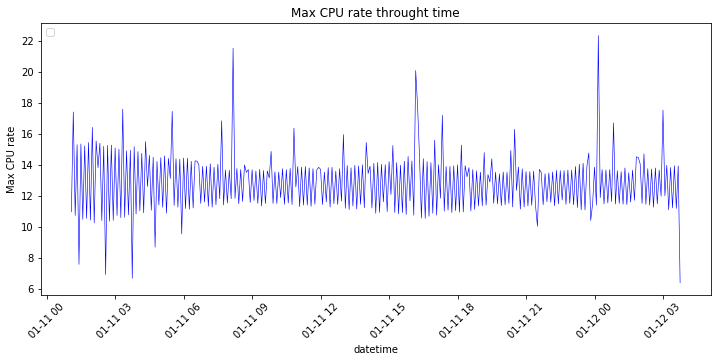

In [11]:
# visualisation of CPU utilization throughout time in train_df
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 5))
# pd.plotting.deregister_matplotlib_converters()

ax.plot(test_df['datetime'], test_df['value'], color='blue', linewidth=0.6)
ax.set_title('Max CPU rate throught time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('Max CPU rate')
plt.legend(loc='upper left')
plt.show()

## 2. train and validation

In [12]:
import ray
ray.init()

2019-11-28 11:53:59,431	INFO node.py:498 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-11-28_11-53-59_431121_12271/logs.
2019-11-28 11:53:59,537	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:60103 to respond...
2019-11-28 11:53:59,660	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:38475 to respond...
2019-11-28 11:53:59,663	INFO services.py:806 -- Starting Redis shard with 3.3 GB max memory.
2019-11-28 11:53:59,676	INFO node.py:512 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-11-28_11-53-59_431121_12271/logs.
2019-11-28 11:53:59,677	INFO services.py:1446 -- Starting the Plasma object store with 4.95 GB memory using /dev/shm.


{'node_ip_address': '10.167.125.219',
 'redis_address': '10.167.125.219:60103',
 'object_store_address': '/tmp/ray/session_2019-11-28_11-53-59_431121_12271/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-11-28_11-53-59_431121_12271/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2019-11-28_11-53-59_431121_12271'}

We use the MTNet in AutoML library to do anomaly detection. The important parameters in MTNet are __T: single unit past sequence length, n: total historical unit length, highway_window: autoregressive window size, past_seq_len: total length that are required for unrolling in preprocessing__.

These parameters should meet the following criteria: 
<center>
highway_window < T, past_seq_len=(n+1)*T
</center>
The following shows a simple recipe used on Google cluster data.

In [13]:
from zoo.automl.regression.time_sequence_predictor import Recipe
from zoo.automl.regression.time_sequence_predictor import TimeSequencePredictor
from zoo.automl.common.util import *
from zoo.automl.search.abstract import *
# self defined recipe
class GoogleClusterSmokeRecipe(Recipe):
    """
    a recipe written for AWS using the MTNet
    """
    def __init__(self):
        pass

    def search_space(self, all_available_features):
        return {
            "selected_features": all_available_features,
            "model": "MTNet",
            "lr": 0.001,
            "batch_size": 100,
            "epochs": 10,
            "n": RandomSample(lambda spec: np.random.choice([2, 3, 4], size=1)[0]),
            "highway_window": 3,
            "T": RandomSample(lambda spec: np.random.choice([3, 4], size=1)[0]),
            # W <= T
            "W": 2,
            'metric': 'mse',
            # can not merge into basic recipes since the definition of past_seq_len varies.
            "past_seq_len": RandomSample(lambda spec: (spec.config.n + 1) * spec.config.T),
        }

    def runtime_params(self):
        return {
            "training_iteration": 1,
            "num_samples": 6,
        }

/home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/henryliu/anaconda3/envs/zoo-

In [14]:
# build time sequence predictor

# you need to specify the name of datetime column and target column
# The default names are "datetime" and "value" respectively.
tsp = TimeSequencePredictor(dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

In [15]:
%%time

# fit train_df and validate with val_df, return the best trial as pipeline.
# the default recipe is SmokeRecipe,which runs one epoch and one iteration with only 1 random sample.
# you can change recipe by define `recipe` in `fit`. The recipes you can choose are SmokeRecipe, RandomRecipe, GridRandomRecipe and BayesRecipe.
pipeline = tsp.fit(train_df,
                   recipe=GoogleClusterSmokeRecipe(),
                   metric="mse")
print("Training completed.")

2019-11-28 11:54:01,125	WARNING worker.py:343 -- WARNING: Falling back to serializing objects of type <class 'zoo.automl.feature.time_sequence.TimeSequenceFeatureTransformer'> by using pickle. This may be inefficient.
2019-11-28 11:54:01,132	INFO tune.py:61 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2019-11-28 11:54:01,144	INFO tune.py:233 -- Starting a new experiment.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/12 CPUs, 0/1 GPUs
Memory usage on this node: 6.0/16.5 GB

(pid=12311) Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=12314) Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=12314) Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=12317) Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=12317) Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=12315) Prepending /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=12315) Prepending /home/henryliu/anacond

(pid=12315) /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=12315)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=12315) /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=12315)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=12315) /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid

(pid=12312) MTNet is selected.
(pid=12312) WARNING:tensorflow:From /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/automl/model/MTNet.py:193: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.
(pid=12312) 
(pid=12312) WARNING:tensorflow:From /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/automl/model/MTNet.py:194: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.
(pid=12312) 
(pid=12312) WARNING:tensorflow:From /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/automl/model/MTNet.py:194: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.
(pid=12312) 
(pid=12317) MTNet is selected.
(pid=12317) WARNING:tensorflow:From /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/automl/model/MTNet.py:193: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.

(pid=12317) 2019-11-28 11:54:19.328543: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=12317) 2019-11-28 11:54:19.352313: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208000000 Hz
(pid=12317) 2019-11-28 11:54:19.352924: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0ad910dc80 executing computations on platform Host. Devices:
(pid=12317) 2019-11-28 11:54:19.352949: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
(pid=12319) 2019-11-28 11:54:19.673372: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=12319) 2019-11-28 11:54:19.678823: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208000000 Hz
(pid=12319) 2019-11-28 11:54:19.679389: I tensorflow/compiler/x

2019-11-28 11:54:25,318	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_4_T=4,n=2,past_seq_len=12. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 8/12 CPUs, 0/1 GPUs
Memory usage on this node: 9.6/16.5 GB
Result logdir: /home/henryliu/ray_results/automl
Number of trials: 6 ({'RUNNING': 4, 'TERMINATED': 2})
RUNNING trials:
 - train_func_0_T=4,n=4,past_seq_len=20:	RUNNING
 - train_func_1_T=4,n=4,past_seq_len=20:	RUNNING
 - train_func_2_T=4,n=4,past_seq_len=20:	RUNNING
 - train_func_5_T=4,n=4,past_seq_len=20:	RUNNING
TERMINATED trials:
 - train_func_3_T=3,n=2,past_seq_len=9:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12318], 14 s, 1 iter
 - train_func_4_T=4,n=2,past_seq_len=12:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12315], 22 s, 1 iter



2019-11-28 11:54:54,419	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_1_T=4,n=4,past_seq_len=20. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/12 CPUs, 0/1 GPUs
Memory usage on this node: 9.4/16.5 GB
Result logdir: /home/henryliu/ray_results/automl
Number of trials: 6 ({'RUNNING': 3, 'TERMINATED': 3})
RUNNING trials:
 - train_func_0_T=4,n=4,past_seq_len=20:	RUNNING
 - train_func_2_T=4,n=4,past_seq_len=20:	RUNNING
 - train_func_5_T=4,n=4,past_seq_len=20:	RUNNING
TERMINATED trials:
 - train_func_1_T=4,n=4,past_seq_len=20:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12317], 51 s, 1 iter
 - train_func_3_T=3,n=2,past_seq_len=9:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12318], 14 s, 1 iter
 - train_func_4_T=4,n=2,past_seq_len=12:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12315], 22 s, 1 iter



2019-11-28 11:54:54,838	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_0_T=4,n=4,past_seq_len=20. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2019-11-28 11:54:55,200	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_5_T=4,n=4,past_seq_len=20. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2019-11-28 11:54:55,226	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_2_T=4,n=4,past_seq_len=20. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/12 CPUs, 0/1 GPUs
Memory usage on this node: 8.7/16.5 GB
Result logdir: /home/henryliu/ray_results/automl
Number of trials: 6 ({'TERMINATED': 6})
TERMINATED trials:
 - train_func_0_T=4,n=4,past_seq_len=20:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12319], 51 s, 1 iter
 - train_func_1_T=4,n=4,past_seq_len=20:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12317], 51 s, 1 iter
 - train_func_2_T=4,n=4,past_seq_len=20:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12308], 51 s, 1 iter
 - train_func_3_T=3,n=2,past_seq_len=9:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12318], 14 s, 1 iter
 - train_func_4_T=4,n=2,past_seq_len=12:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12315], 22 s, 1 iter
 - train_func_5_T=4,n=4,past_seq_len=20:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12312], 52 s, 1 iter

The best configurations are:
selected_features : ['MONTH(datetime)', 'WEEKDAY(datetime)', 'DAY(datetime)', 'HOUR(datetime)', 'IS_WEEKEND(datetime)', 'IS_AWAKE(datetime)', 'IS_BUSY_HOUR

Training completed.
CPU times: user 14.4 s, sys: 568 ms, total: 14.9 s
Wall time: 1min 6s


We evaluate our prediction with different matrics.

In [16]:
result = pipeline.evaluate(val_df, ['mse', 'smape', 'r2'])
print("Evaluation result on validation set:")
print("mse:%f, smape:%f, r2:%f" % tuple(result) )

Evaluation result on validation set:
mse:1.851833, smape:3.466133, r2:0.405102


## 3. visualization

The following part shows two different method to detect anomaly based on existing prediction. 

The first uses percentile anomaly, where a preset fraction will be determined resulting in a fixed number of anomaly. It will compare the difference between predicted and actual value and assign the several largest differences as anomaly. 


In [17]:
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

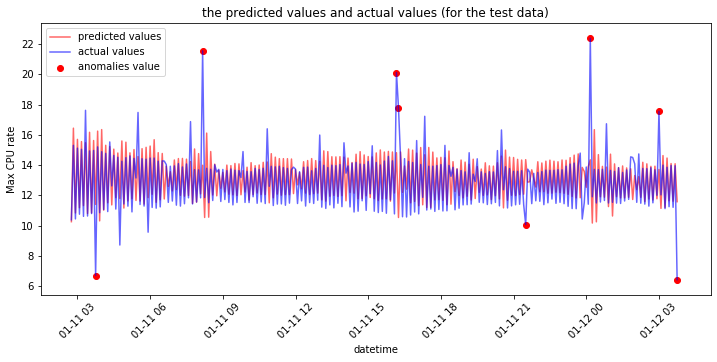

In [18]:
plot_result_with_percentile_anomaly(test_df, pred_df, outliers_fraction=0.03)

The second is using uncertainty quantification. The AutoML model is integrated with dropouts that can produce stochastic prediction using a single pretrained model. The prediction will be the average value and the uncertainty will be the deviation of these different results on a single point. This uncertainty would be used to construct an confidencial interval for further anomaly detection

To use this, use __pipeline.predict_with_uncertainty__

In [19]:
pred_df, uncertainty = pipeline.predict_with_uncertainty(test_df)

In [20]:
pred_df.head()

,datetime,value
0,2019-01-11 02:45:00,10.195563
1,2019-01-11 02:50:00,16.431468
2,2019-01-11 02:55:00,10.794493
3,2019-01-11 03:00:00,15.726871
4,2019-01-11 03:05:00,11.151737


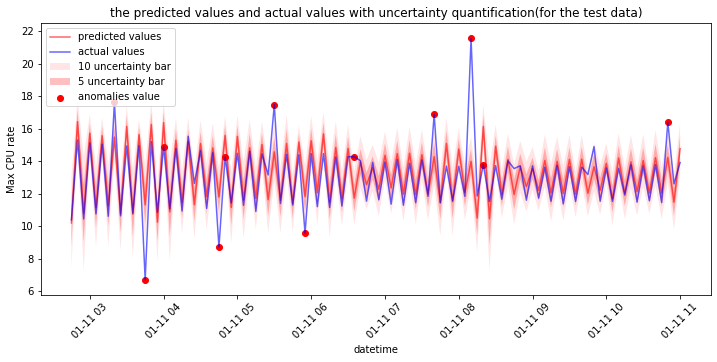

In [21]:
plot_result_with_uncertainty_anomaly(test_df, pred_df, uncertainty, plot_size=100)

## 4. multivariable prediction

One of the advantage of MTNet is that is can smoothly transfer to multivariable settings. The following shows multivaraible example using MTNet on Google cluster data. The multivariable data come from concatinating two different machines during a same period of time.

In [22]:
try:
    import pickle
    with open('dataset/machines/machine-1.pkl', 'rb') as file:
        azure1 =pickle.load(file)
    with open('dataset/machines/machine-4.pkl', 'rb') as file:
        azure4 =pickle.load(file)
except Exception as e:
    print("machine-0.pkl or machine-4.pkl doesn't exist")
    #print("you can run $ANALYTICS_ZOO_HOME/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh to download nyc_taxi.csv")

In [23]:
multi_df = pd.merge(azure1, azure4, on='timestamp')
# discard the tail where timestep is ununiform
multi_df = multi_df.iloc[:5000]
# multi_df['multi_value'] = list(np.c_[multi_df.value_x, multi_df.value_y].reshape(-1, 2))

from zoo.automl.common.util import split_input_df
train_df, val_df, test_df = split_input_df(multi_df, val_split_ratio=0.1, test_split_ratio=0.1)

In [24]:
train_df.head()

,datetime,value_x,value_y
0,2019-01-01 00:00:00,17.250655,4.833578
1,2019-01-01 00:05:00,18.624668,3.318487
2,2019-01-01 00:10:00,19.541448,3.212983
3,2019-01-01 00:15:00,20.347041,3.274958
4,2019-01-01 00:20:00,21.744101,3.354650


No handles with labels found to put in legend.


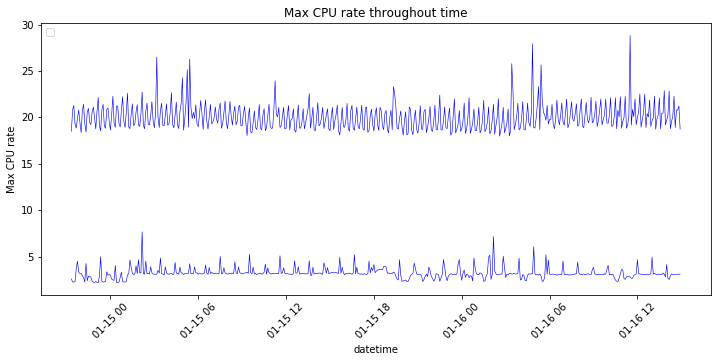

In [25]:
# visualisation of CPU utilization throughout time in train_df
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 5))
# pd.plotting.deregister_matplotlib_converters()

ax.plot(val_df['datetime'], val_df['value_x'], color='blue', linewidth=0.6)
ax.plot(val_df['datetime'], val_df['value_y'], color='blue', linewidth=0.6)
ax.set_title('Max CPU rate throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('Max CPU rate')
plt.legend(loc='upper left')
plt.show()

To use the multivariable prediction, set __K__ into __input_dimension__ in the configuration and set __future_seq_len__ into 1(as default).

In [26]:
from zoo.automl.regression.time_sequence_predictor import Recipe
from zoo.automl.regression.time_sequence_predictor import TimeSequencePredictor
from zoo.automl.common.util import *
from zoo.automl.search.abstract import *
# self defined recipe
class MultiRecipe(Recipe):
    """
    a recipe written for AWS using the MTNet
    """
    def __init__(self):
        pass

    def search_space(self, all_available_features):
        return {
            "selected_features": all_available_features,
            "model": "MTNet",
            "lr": 0.001,
            "batch_size": 100,
            "epochs": 10,
            "n": RandomSample(lambda spec: np.random.choice([2, 3, 4], size=1)[0]),
            "highway_window": 3,
            "T": RandomSample(lambda spec: np.random.choice([3, 4], size=1)[0]),
            # W <= T
            "K": 2,
            "W": 2,
            'metric': 'mse',
            # can not merge into basic recipes since the definition of past_seq_len varies.
            "past_seq_len": RandomSample(lambda spec: (spec.config.n + 1) * spec.config.T),
        }

    def runtime_params(self):
        return {
            "training_iteration": 1,
            "num_samples": 6,
        }

The multivaraibles column could be specified by passing a list to __target_col__

In [27]:
# build time sequence predictor

# you need to specify the name of datetime column and target column
# The default names are "datetime" and "value" respectively.
tsp2 = TimeSequencePredictor(name='multi', dt_col="datetime",
                            target_col=["value_x", "value_y"],
                            extra_features_col=None)

In [28]:
%%time

# fit train_df and validate with val_df, return the best trial as pipeline.
# the default recipe is SmokeRecipe,which runs one epoch and one iteration with only 1 random sample.
# you can change recipe by define `recipe` in `fit`. The recipes you can choose are SmokeRecipe, RandomRecipe, GridRandomRecipe and BayesRecipe.
pipeline2 = tsp2.fit(train_df,
                   recipe=MultiRecipe(),
                   metric="mse")
print("Training completed.")

2019-11-28 11:55:13,144	INFO tune.py:61 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2019-11-28 11:55:13,144	INFO tune.py:233 -- Starting a new experiment.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/12 CPUs, 0/1 GPUs
Memory usage on this node: 6.7/16.5 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/12 CPUs, 0/1 GPUs
Memory usage on this node: 6.7/16.5 GB
Result logdir: /home/henryliu/ray_results/multi
Number of trials: 6 ({'RUNNING': 1, 'PENDING': 5})
PENDING trials:
 - train_func_1_T=4,n=4,past_seq_len=20:	PENDING
 - train_func_2_T=4,n=2,past_seq_len=12:	PENDING
 - train_func_3_T=3,n=4,past_seq_len=15:	PENDING
 - train_func_4_T=3,n=2,past_seq_len=9:	PENDING
 - train_func_5_T=4,n=4,past_seq_len=20:	PENDING
RUNNING trials:
 - train_func_0_T=4,n=4,past_seq_len=20:	RUNNING

(pid=12309) /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=12309)   _np_qint8 = np.dtype([("

(pid=12310) /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=12310)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=12310) /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=12310)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=12310) /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid

(pid=12314) WARNING:tensorflow:From /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/automl/model/MTNet.py:193: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.
(pid=12314) 
(pid=12314) WARNING:tensorflow:From /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/automl/model/MTNet.py:194: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.
(pid=12314) 
(pid=12314) WARNING:tensorflow:From /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/automl/model/MTNet.py:194: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.
(pid=12314) 
(pid=12314) MTNet is selected.
(pid=12309) WARNING:tensorflow:From /home/henryliu/anaconda3/envs/zoo-work/lib/python3.7/site-packages/zoo/automl/model/MTNet.py:193: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.
(p

(pid=12314) 2019-11-28 11:55:32.336242: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=12314) 2019-11-28 11:55:32.364328: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208000000 Hz
(pid=12314) 2019-11-28 11:55:32.364907: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff7d12c5d10 executing computations on platform Host. Devices:
(pid=12314) 2019-11-28 11:55:32.364943: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
(pid=12310) 2019-11-28 11:55:32.561191: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=12310) 2019-11-28 11:55:32.567547: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208000000 Hz
(pid=12310) 2019-11-28 11:55:32.568062: I tensorflow/compiler/x

2019-11-28 11:55:52,996	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_2_T=4,n=2,past_seq_len=12. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 8/12 CPUs, 0/1 GPUs
Memory usage on this node: 9.6/16.5 GB
Result logdir: /home/henryliu/ray_results/multi
Number of trials: 6 ({'RUNNING': 4, 'TERMINATED': 2})
RUNNING trials:
 - train_func_0_T=4,n=4,past_seq_len=20:	RUNNING
 - train_func_1_T=4,n=4,past_seq_len=20:	RUNNING
 - train_func_3_T=3,n=4,past_seq_len=15:	RUNNING
 - train_func_5_T=4,n=4,past_seq_len=20:	RUNNING
TERMINATED trials:
 - train_func_2_T=4,n=2,past_seq_len=12:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12313], 38 s, 1 iter
 - train_func_4_T=3,n=2,past_seq_len=9:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12316], 22 s, 1 iter



2019-11-28 11:56:02,101	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_3_T=3,n=4,past_seq_len=15. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/12 CPUs, 0/1 GPUs
Memory usage on this node: 9.1/16.5 GB
Result logdir: /home/henryliu/ray_results/multi
Number of trials: 6 ({'RUNNING': 3, 'TERMINATED': 3})
RUNNING trials:
 - train_func_0_T=4,n=4,past_seq_len=20:	RUNNING
 - train_func_1_T=4,n=4,past_seq_len=20:	RUNNING
 - train_func_5_T=4,n=4,past_seq_len=20:	RUNNING
TERMINATED trials:
 - train_func_2_T=4,n=2,past_seq_len=12:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12313], 38 s, 1 iter
 - train_func_3_T=3,n=4,past_seq_len=15:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12311], 48 s, 1 iter
 - train_func_4_T=3,n=2,past_seq_len=9:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12316], 22 s, 1 iter



2019-11-28 11:56:20,833	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_5_T=4,n=4,past_seq_len=20. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/12 CPUs, 0/1 GPUs
Memory usage on this node: 8.5/16.5 GB
Result logdir: /home/henryliu/ray_results/multi
Number of trials: 6 ({'RUNNING': 2, 'TERMINATED': 4})
RUNNING trials:
 - train_func_0_T=4,n=4,past_seq_len=20:	RUNNING
 - train_func_1_T=4,n=4,past_seq_len=20:	RUNNING
TERMINATED trials:
 - train_func_2_T=4,n=2,past_seq_len=12:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12313], 38 s, 1 iter
 - train_func_3_T=3,n=4,past_seq_len=15:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12311], 48 s, 1 iter
 - train_func_4_T=3,n=2,past_seq_len=9:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12316], 22 s, 1 iter
 - train_func_5_T=4,n=4,past_seq_len=20:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12314], 66 s, 1 iter



2019-11-28 11:56:21,228	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_0_T=4,n=4,past_seq_len=20. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2019-11-28 11:56:21,281	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_1_T=4,n=4,past_seq_len=20. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/12 CPUs, 0/1 GPUs
Memory usage on this node: 8.6/16.5 GB
Result logdir: /home/henryliu/ray_results/multi
Number of trials: 6 ({'TERMINATED': 6})
TERMINATED trials:
 - train_func_0_T=4,n=4,past_seq_len=20:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12309], 67 s, 1 iter
 - train_func_1_T=4,n=4,past_seq_len=20:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12310], 67 s, 1 iter
 - train_func_2_T=4,n=2,past_seq_len=12:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12313], 38 s, 1 iter
 - train_func_3_T=3,n=4,past_seq_len=15:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12311], 48 s, 1 iter
 - train_func_4_T=3,n=2,past_seq_len=9:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12316], 22 s, 1 iter
 - train_func_5_T=4,n=4,past_seq_len=20:	TERMINATED, [2 CPUs, 0 GPUs], [pid=12314], 66 s, 1 iter

The best configurations are:
selected_features : ['MONTH(datetime)', 'WEEKDAY(datetime)', 'DAY(datetime)', 'HOUR(datetime)', 'IS_WEEKEND(datetime)', 'IS_AWAKE(datetime)', 'IS_BUSY_HOURS

Training completed.
CPU times: user 9.47 s, sys: 491 ms, total: 9.96 s
Wall time: 1min 15s


In [29]:
pipeline2.feature_transformers.target_col

['value_x', 'value_y']

The validation procedure follows previous example.

In [30]:
result = pipeline2.evaluate(test_df, ['mse', 'smape', 'r2'])
print("Evaluation result on testing set:")
print("machine X:  mse:%f, smape:%f, r2:%f" % (result[0][0], result[1][0], result[2][0]) )
print("machine Y:  mse:%f, smape:%f, r2:%f" % (result[0][1], result[1][1], result[2][1]) )

Evaluation result on testing set:
machine X:  mse:1.300415, smape:1.710514, r2:0.381135
machine Y:  mse:0.401185, smape:5.381494, r2:-0.069076


In [31]:
# predict test_df with the best trial
pred_df = pipeline2.predict(test_df)

In [32]:
pred_df.head()

,datetime,value_x,value_y
0,2019-01-16 16:00:00,19.583039,2.981630
1,2019-01-16 16:05:00,20.241532,2.715718
2,2019-01-16 16:10:00,20.785166,3.683924
3,2019-01-16 16:15:00,19.640819,3.372531
4,2019-01-16 16:20:00,19.821543,3.459978


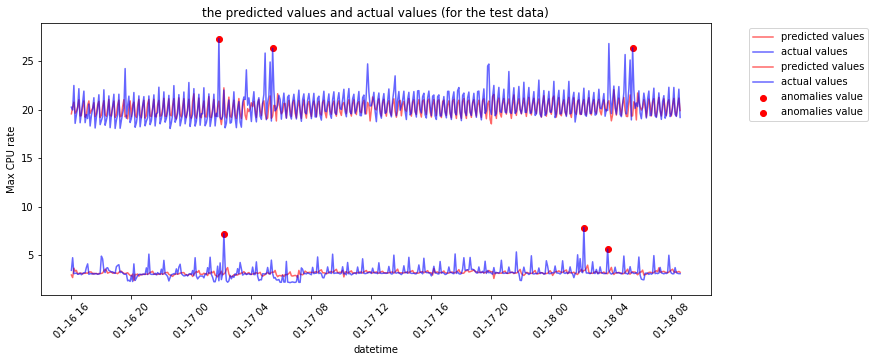

In [33]:
multi_plot_result_with_percentile_anomaly(test_df, pred_df, outliers_fraction=0.01, plot_size=None)

In [34]:
pred_df, uncertainty = pipeline2.predict_with_uncertainty(test_df)

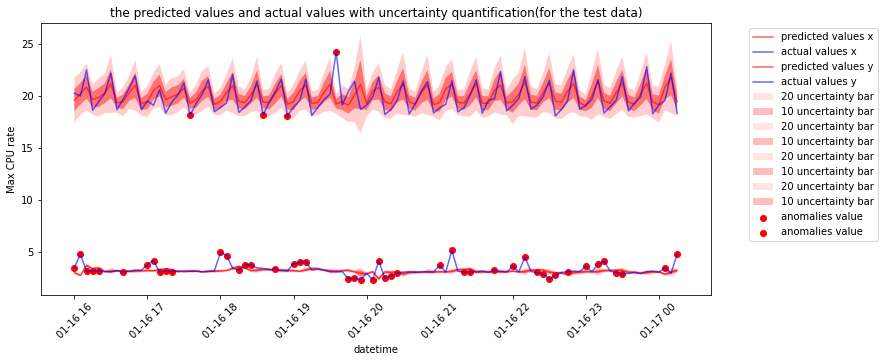

In [35]:
multi_plot_result_with_uncertainty_anomaly(test_df, pred_df, uncertainty, plot_size=100)